# <center>**Práctica 2: Trabajo de Investigación**</center>
## <center>Procesamiento de Imagen, Vídeo y Audio</center>
### <center>Grado en Ciencia e Ingeniería de Datos</center>
### <center>Curso 2022/2023</center>

In [1]:
import skimage.io as io
import scipy as sp
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt

### **1. Ejercicio 1: Segmentación de carreteras en imagen aérea de alta resolución**

In [48]:
# cargamos los datos de la carpeta data 
data = io.imread_collection('data/roads/sat/*.tiff')
labels = io.imread_collection('data/roads/gt/*.tif')

#### Preprocesado de las imágenes

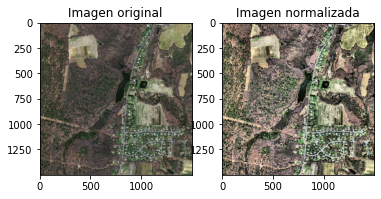

In [58]:
from skimage import exposure

# Normalización de imágenes
norm_data = []
for img in data:
    norm_img = exposure.equalize_adapthist(img, clip_limit=0.03) # Normaliza la imagen usando la corrección de contraste adaptativo
    norm_data.append(norm_img)

# Visualización de una imagen normalizada
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data[0])
ax1.set_title('Imagen original')
ax2.imshow(norm_data[0])
ax2.set_title('Imagen normalizada')
plt.show()

C:\Users\Administrador\AppData\Local\Temp\ipykernel_10068\514371662.py:6: FutureWarning: Automatic detection of the color channel was deprecated in v0.19, and `channel_axis=None` will be the new default in v0.21. Set `channel_axis=-1` explicitly to silence this warning.
  smooth_img = gaussian(img, sigma=1) # Filtro Gaussiano con sigma=1


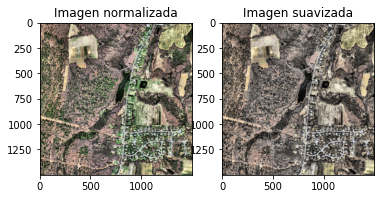

In [59]:
from skimage.filters import gaussian, median

# Eliminación de ruido 
smooth_data = []
for img in norm_data:
    smooth_img = gaussian(img, sigma=1) # Filtro Gaussiano con sigma=1
    smooth_img = median(smooth_img) # Filtro de mediana con tamaño de ventana predeterminado
    smooth_data.append(smooth_img)

# Visualización de una imagen suavizada
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(norm_data[0])
ax1.set_title('Imagen normalizada')
ax2.imshow(smooth_data[0])
ax2.set_title('Imagen suavizada')
plt.show()

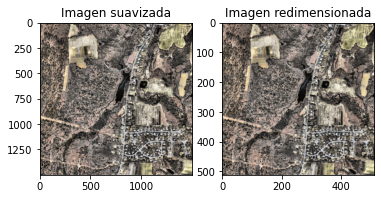

In [60]:
from skimage.transform import resize

# Ajuste de la resolución de las imágenes
resized_data = []
for i in range(len(smooth_data)):
    resized_img = resize(smooth_data[i], (512, 512), anti_aliasing=True)
    resized_data.append(resized_img)

# Visualización de una imagen redimensionada
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(smooth_data[0])
ax1.set_title('Imagen suavizada')
ax2.imshow(resized_data[0])
ax2.set_title('Imagen redimensionada')
plt.show()

#### Baseline

In [66]:
# Creamos un autoencoder convolucional que aprenda características de las imágenes 
# y las reconstruya
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Conv2DTranspose, Dropout, BatchNormalization
from keras.models import Sequential, Model

input_img = Input(shape=(512, 512, 3))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# autoencoder.summary()

In [65]:
# Entrenamos el autoencoder
from sklearn.model_selection import train_test_split

# dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(resized_data, labels, test_size=0.2, random_state=42)

# convertir los datos a un array de numpy
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# entrenar el modelo
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_val, X_val))

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.0483 - accuracy: 0.1266 - val_loss: 0.0485 - val_accuracy: 0.1240
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 0.0480 - accuracy: 0.1353 - val_loss: 0.0481 - val_accuracy: 0.1737
Epoch 3/10
1/1 [==============================] - 8s 8s/step - loss: 0.0476 - accuracy: 0.1851 - val_loss: 0.0478 - val_accuracy: 0.2860
Epoch 4/10
1/1 [==============================] - 7s 7s/step - loss: 0.0472 - accuracy: 0.2997 - val_loss: 0.0473 - val_accuracy: 0.4463
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 0.0467 - accuracy: 0.4558 - val_loss: 0.0468 - val_accuracy: 0.5983
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 0.0461 - accuracy: 0.6010 - val_loss: 0.0464 - val_accuracy: 0.7488
Epoch 7/10
1/1 [==============================] - 6s 6s/step - loss: 0.0455 - accuracy: 0.7451 - val_loss: 0.0462 - val_accuracy: 0.8447
Epoch 8/10
1/1 [=========================

#### Extracción de características

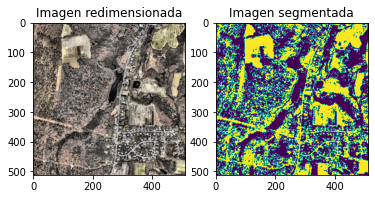

In [67]:
# Segmentación de color de las imágenes
from skimage.color import rgb2hsv
from skimage.filters import threshold_otsu

segmented_data = []
for img in resized_data:
    hsv_img = rgb2hsv(img)
    v = hsv_img[:, :, 2]
    thresh = threshold_otsu(v)
    binary = v > thresh
    segmented_data.append(binary)

# Visualización de una imagen segmentada
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(resized_data[0])
ax1.set_title('Imagen redimensionada')
ax2.imshow(segmented_data[0])
ax2.set_title('Imagen segmentada')
plt.show()

In [68]:
# convert resized_data to grayscale in one line
gray_resized_data = [np.dot(img[...,:3], [0.299, 0.587, 0.114]) for img in resized_data]

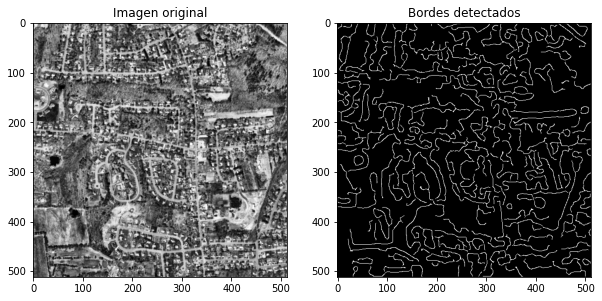

In [69]:
from skimage import feature

# Detección de bordes utilizando el operador Canny
# convertir resized_data a escala de grises
edges = []
for i in range(len(gray_resized_data)):
    edge = feature.canny(gray_resized_data[i], sigma=4, low_threshold=0.05, high_threshold=0.2)
    edges.append(edge)

# Visualización de la imagen original y los bordes detectados
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(gray_resized_data[2], cmap='gray')
ax1.set_title('Imagen original')
ax2.imshow(edges[2], cmap='gray')
ax2.set_title('Bordes detectados')
plt.show()

#### Entrenamiento del modelo

In [73]:
# Obtenemos nuevos conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(edges, labels, test_size=0.2, random_state=42)

# convertir los datos a un array de numpy
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

In [75]:
input_img = Input(shape=(512, 512, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [76]:
autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, validation_data=(X_val, X_val))

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.2481 - accuracy: 0.8449 - val_loss: 0.2435 - val_accuracy: 0.9302
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 0.2436 - accuracy: 0.9315 - val_loss: 0.2361 - val_accuracy: 0.9318
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 0.2363 - accuracy: 0.9333 - val_loss: 0.2245 - val_accuracy: 0.9320
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 0.2249 - accuracy: 0.9336 - val_loss: 0.2078 - val_accuracy: 0.9321
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 0.2085 - accuracy: 0.9337 - val_loss: 0.1858 - val_accuracy: 0.9321
Epoch 6/10
1/1 [==============================] - 6s 6s/step - loss: 0.1869 - accuracy: 0.9337 - val_loss: 0.1594 - val_accuracy: 0.9321
Epoch 7/10
1/1 [==============================] - 6s 6s/step - loss: 0.1610 - accuracy: 0.9337 - val_loss: 0.1313 - val_accuracy: 0.9321
Epoch 8/10
1/1 [=========================